##### Copyright 2023 Google LLC

In [1]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Setup

In [2]:
!pip install -U -q "google-generativeai>=0.8.2"

In [4]:
# import necessary modules.

import google.generativeai as genai

import base64
import json

try:
    # Mount google drive
    from google.colab import drive

    # Changed the mount point to '/content/drive'
    drive.mount("/content/drive")

    # The SDK will automatically read it from the GOOGLE_API_KEY environment variable.
    # In Colab get the key from Colab-secrets ("🔑" in the left panel).
    import os
    from google.colab import userdata

    os.environ["GOOGLE_API_KEY"] = userdata.get("GOOGLE_API_KEY")
except ImportError:
    pass

# Parse the arguments

model = "gemini-2-flash"  # @param {isTemplate: true}
contents_b64 = b'W3sicGFydHMiOiBbeyJ0ZXh0IjogIkhlbGxvIn1dfV0='
generation_config_b64 = "e30="  # @param {isTemplate: true}
safety_settings_b64 = "e30="  # @param {isTemplate: true}

contents = json.loads(base64.b64decode(contents_b64))

generation_config = json.loads(base64.b64decode(generation_config_b64))
safety_settings = json.loads(base64.b64decode(safety_settings_b64))

stream = False

print(json.dumps(contents, indent=4))

Mounted at /content/drive
[
    {
        "parts": [
            {
                "text": "Hello"
            }
        ]
    }
]


## Call `generate_content`

In [13]:
from google.colab import userdata
GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

In [14]:
import google.generativeai as genai # Make sure genai is imported

models = genai.list_models() # Call list_models on genai
print(models)

<generator object list_models at 0x7b6333778940>


In [15]:
from IPython.display import display
from IPython.display import Markdown
model = "gemini-2-flash"  # @param {isTemplate: true}

# Call the model and print the response.
gemini = genai.GenerativeModel(model_name=model)

response = gemini.generate_content(
    contents,
    generation_config=generation_config,
    safety_settings=safety_settings,
    stream=stream,
)

display(Markdown(response.text))

NotFound: 404 POST https://generativelanguage.googleapis.com/v1beta/models/gemini-2-flash:generateContent?%24alt=json%3Benum-encoding%3Dint: models/gemini-2-flash is not found for API version v1beta, or is not supported for generateContent. Call ListModels to see the list of available models and their supported methods.

In [16]:
from google.generativeai import GenerativeModel

# Initialize the model
gemini = GenerativeModel()

# List available models
available_models = gemini.list_models()
print("Available models:", available_models)

AttributeError: 'GenerativeModel' object has no attribute 'list_models'

In [17]:
from google.generativeai import GenerativeModel

# Initialize the model
gemini = GenerativeModel()

# List available models
available_models = list(gemini.list_models())  # Convert generator to list
print("Available models:")
for model in available_models:
    print(model)

AttributeError: 'GenerativeModel' object has no attribute 'list_models'

In [18]:
from google.generativeai import GenerativeModel, list_models

# List available models
available_models = list_models()  # Use the function directly
print("Available models:")
for model in available_models:
    print(model)

Available models:
Model(name='models/chat-bison-001',
      base_model_id='',
      version='001',
      display_name='PaLM 2 Chat (Legacy)',
      description='A legacy text-only model optimized for chat conversations',
      input_token_limit=4096,
      output_token_limit=1024,
      supported_generation_methods=['generateMessage', 'countMessageTokens'],
      temperature=0.25,
      max_temperature=None,
      top_p=0.95,
      top_k=40)
Model(name='models/text-bison-001',
      base_model_id='',
      version='001',
      display_name='PaLM 2 (Legacy)',
      description='A legacy model that understands text and generates text as an output',
      input_token_limit=8196,
      output_token_limit=1024,
      supported_generation_methods=['generateText', 'countTextTokens', 'createTunedTextModel'],
      temperature=0.7,
      max_temperature=None,
      top_p=0.95,
      top_k=40)
Model(name='models/embedding-gecko-001',
      base_model_id='',
      version='001',
      display_nam

Saving download (4).png to download (4) (4).png
Bounding boxes for download (4) (4).png: [[510, 214, 693, 397, 'harmful'], [517, 200, 625, 275, 'harmless'], [500, 612, 556, 658, 'harmless'], [497, 545, 548, 583, 'harmless'], [500, 466, 535, 496, 'harmless']]


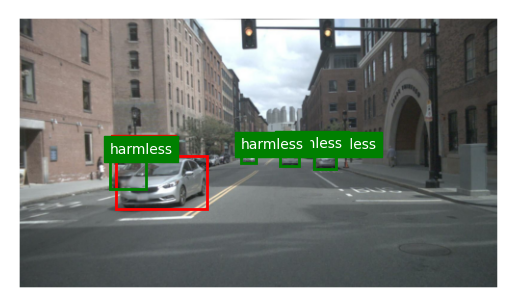

In [24]:
from google.colab import files
from PIL import Image
import io
import re
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from google.generativeai import GenerativeModel

# Initialize the Gemini model (choose the appropriate one)
model_name = 'models/gemini-2.0-flash'  # or 'models/gemini-2.0-flash-001'
gemini = GenerativeModel(model_name=model_name)

def resize_image(image, target_height=768, target_width=768):
    """Resize the image while maintaining the aspect ratio."""
    width, height = image.size
    if width <= 384 and height <= 384:
        # Resize to a minimum size for better processing
        new_size = (max(384, width), max(384, height))
        return image.resize(new_size, Image.ANTIALIAS)
    return image

# Step 1: Upload the image file
uploaded = files.upload()
image_path = list(uploaded.keys())[0]  # Get the uploaded image filename

# Step 2: Open the uploaded image
im = Image.open(image_path)
im = resize_image(im)  # Resize the image if necessary
im.show()

# Step 3: Generate bounding boxes using the selected Gemini model
response = gemini.generate_content([
    im,
    (
        """Return a bounding box for each of the cars in this image.
           Assume the car in the foreground is the reference vehicle.
           Identify other cars that might cause it to change speed or direction
           and label them as harmful. Otherwise, label them as harmless
           in [ymin, xmin, ymax, xmax, label] format."""
    ),
])

# Step 4: Parse bounding boxes from the response text
def parse_list_boxes(text):
    result = []
    # Find all occurrences of bounding boxes with labels
    matches = re.findall(r"\[(\d+),\s*(\d+),\s*(\d+),\s*(\d+),\s*(harmless|harmful)]", text)
    for match in matches:
        result.append([int(x) for x in match[:-1]] + [match[-1]])  # Add the label as well
    return result

# Extract bounding boxes
boxes = parse_list_boxes(response.text)
print(f"Bounding boxes for {image_path}: {boxes}")

# Step 5: Function to plot bounding boxes on the image
def plot_bounding_boxes(image, boxes):
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Get image dimensions
    width, height = image.size

    # Add bounding boxes to the image
    for bbox in boxes:
        ymin, xmin, ymax, xmax, label = bbox

        # Normalize coordinates (assuming model output is normalized to 1000)
        xmin = int(xmin / 1000 * width)
        ymin = int(ymin / 1000 * height)
        xmax = int(xmax / 1000 * width)
        ymax = int(ymax / 1000 * height)

        # Draw bounding box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2,
                                 edgecolor='green' if label == 'harmless' else 'red',
                                 facecolor='none')
        ax.add_patch(rect)

        # Optionally, add the label text
        ax.text(xmin, ymin - 5, label, color='white', fontsize=10,
                backgroundcolor='green' if label == 'harmless' else 'red')

    plt.axis('off')  # Hide axes
    plt.show()

# Step 6: Plot the bounding boxes on the image
plot_bounding_boxes(im, boxes)  # Passing boxes to the function

In [9]:
from IPython.display import display
from IPython.display import Markdown

# Call the model and print the response.
# Changed the model name to "models/gemini-pro"
gemini = genai.GenerativeModel(model_name="models/gemini-pro")

response = gemini.generate_content(
    contents,
    generation_config=generation_config,
    safety_settings=safety_settings,
    stream=stream,
)

display(Markdown(response.text))

Hello there! How can I assist you today?

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://ai.google.dev/gemini-api/docs"><img src="https://ai.google.dev/static/site-assets/images/docs/notebook-site-button.png" height="32" width="32" />Docs on ai.google.dev</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google-gemini/cookbook/blob/main/quickstarts"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />More notebooks in the Cookbook</a>
  </td>
</table>